## 양방향 LSTM를 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)
품사 태깅에 대해서는 이미 텍스트 전처리 챕터에서 토큰화와 함께 언급한 바 있습니다. 그 당시에는 NLTK와 KoNLPy를 이용해서 품사 태깅을 수행하였지만, 여기서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델을 만들어봅니다.

### 1. 품사 태깅 데이터에 대한 이해와 전처리
양방향 LSTM을 이용해서 품사 태깅을 하는 모델을 만들어보겠습니다.

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2022-04-08 10:18:56.723801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 10:18:56.723856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### 1) 데이터 로드하기
NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있습니다. 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어보겠습니다. 전체 문장 샘플의 개수를 확인합니다.

In [2]:
# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


첫번째 샘플만 출력해보겠습니다.

In [3]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


품사 태깅 전처리가 수행된 첫번째 문장이 출력된 것을 볼 수 있습니다. 이러한 문장 샘플이 총 3,914개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('Pierre', 'NNP'), ('Vinken', 'NNP')]와 같은 문장 샘플이 있다면 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장할 필요가 있습니다.  

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 동일한 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다.

In [4]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 pos_tags에 저장하였습니다.  

첫번째 문장 샘플을 출력해보겠습니다.

In [5]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


첫번째 샘플에 대해서 단어에 대해서 sentences[0]에, 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있습니다.  
뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 pos_tags는 예측 대상인 y에 해당됩니다. 임의로 8번 인덱스 샘플에 대해서도 확인해보겠습니다.

In [6]:
print("문장의 단어수:",len(sentences[8]))
print(sentences[8])
print("문장에 대한 품사 태그수:",len(pos_tags[8]))
print(pos_tags[8])

문장의 단어수: 16
['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
문장에 대한 품사 태그수: 16
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


단어에 대해서만 sentences[8]에, 또한 품사에 대해서만 pos_tags[8]에 저장된 것을 확인할 수 있습니다.  
또한 첫번째 샘플(sentences[0])과 길이(18개)가 다른 것을 볼 수 있습니다. 사실 3,914개의 문장 샘플의 길이는 전부 제각각입니다.  

#### 2) 데이터 정제하기
전체 데이터의 길이 분포를 확인해봅시다.

샘플 문장 단어의 최대 길이 : 271
샘플 문장 단어의 평균 길이 : 25.722024


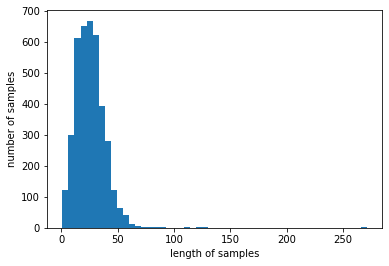

In [7]:
print('샘플 문장 단어의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플 문장 단어의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 대부분의 샘플의 길이가 150 이내며 대부분 0~50의 길이를 가지는 것을 보여줍니다. 

#### 3) 정수 인코딩
이제 케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 우선 케라스 토크나이저를 다음과 같이 함수로 구현합니다.

In [8]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

입력값(X값)이 되는 문장 데이터에 대해서는 src_tokenizer를, 출력값(Y값)이 되는 레이블에 해당되는 품사 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [9]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

토크나이징된 입력 값과 출력 값 결과를 확인해 봅니다

In [13]:
print('X값 문장 :',src_tokenizer.word_index)
print('Y값 태깅 :',tar_tokenizer.word_index)

입력 문장 : {',': 1, 'the': 2, '.': 3, 'of': 4, 'to': 5, 'a': 6, 'in': 7, 'and': 8, '*-1': 9, '0': 10, '*': 11, "'s": 12, 'for': 13, 'that': 14, '*t*-1': 15, '*u*': 16, '$': 17, '``': 18, "''": 19, 'is': 20, 'said': 21, 'it': 22, 'on': 23, '%': 24, 'by': 25, 'at': 26, 'as': 27, 'with': 28, 'from': 29, 'million': 30, 'mr.': 31, '*-2': 32, 'are': 33, 'was': 34, 'be': 35, '*t*-2': 36, 'its': 37, 'has': 38, 'an': 39, 'new': 40, 'have': 41, "n't": 42, 'but': 43, 'he': 44, 'or': 45, 'will': 46, 'they': 47, 'company': 48, '--': 49, 'which': 50, 'this': 51, 'u.s.': 52, 'says': 53, 'year': 54, 'about': 55, 'would': 56, 'more': 57, 'were': 58, 'market': 59, 'their': 60, 'than': 61, 'stock': 62, ';': 63, 'who': 64, 'trading': 65, 'had': 66, 'also': 67, 'president': 68, 'billion': 69, 'up': 70, 'one': 71, 'been': 72, 'some': 73, ':': 74, 'other': 75, 'not': 76, 'program': 77, '*-3': 78, 'his': 79, 'because': 80, 'if': 81, 'could': 82, 'share': 83, 'corp.': 84, 'all': 85, 'years': 86, 'i': 87, 'first':

X값 단어 집합과 Y값 품사 태깅 정보 집합의 크기를 확인해보겠습니다.

In [14]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('X값 단어 집합의 크기 : {}'.format(vocab_size))
print('Y값 태깅 정보 집합의 크기 : {}'.format(tag_size))

X값 단어 집합의 크기 : 11388
Y값 태깅 정보 집합의 크기 : 47


정수 인코딩을 수행합니다.

In [15]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_train, 품사 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_train에 저장되었습니다.  

정수 인코딩이 되었는지 확인을 위해 임의로 2번 인덱스 샘플을 출력해보겠습니다.

In [16]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


#### 4) 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 150 이내입니다. X에 해당되는 데이터 X_train의 샘플들과 y에 해당되는 데이터 y_train 샘플들의 모든 길이를 임의로 150정도로 맞추어 보겠습니다.  

케라스의 pad_sequences()를 사용합니다.

In [17]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

#### 5) 학습데이터와 테스트 데이터 분리
사이킷런(scikit-learn)의 model_selection 패키지 안에 train_test_split 모듈을 활용하여 손쉽게 train set(학습 데이터 셋)과 test set(테스트 셋)을 분리할 수 있습니다.  

정확히 말하면, train / test 가 아닌 train / validation 으로 볼 수 있습니다. (어차피 용어의 차이긴 하지만요)

머신러닝 모델에 train 데이터를 100% 학습시킨 후 test 데이터에 모델을 적용했을 때 성능이 생각보다 않 나오는 경우가 많습니다 (거의 99.999% 는요)

이러한 현상을 보통 Overfitting 되었다라고 합니다.

즉, 모델이 내가 가진 학습 데이터에 너무 과적합되도록 학습한 나머지, 이를 조금이라도 벗어난 케이스에 대해서는 예측율이 현저히 떨어지기 때문이라고 이해하시면 됩니다. 그렇기 때문에 Overfitting을 방지하는 것은 전체적인 모델 성능을 따져보았을 때 매우 중요한 프로세스 중 하나입니다.  
  
기존 train / test로 구분 되어 있었던 데이터 셋을 train에서 train / validation으로 일정 비율 쪼갠 다음에 학습 시에는 train 셋으로 학습 후 중간중간 validation 셋으로 내가 학습한 모델 평가를 해주는 것입니다.

만약, 모델이 과적합되었다면, validation 셋으로 검증시 예측율이나 오차율이 떨어지는 현상을 확인할 수 있으며, 이런 현상이 나타나면 학습을 종료합니다.  
  
**옵션 값 설명**
 - test_size: 테스트 셋 구성의 비율을 나타냅니다. train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해 줍니다. 0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미입니다. default 값은 0.25 입니다.
 - shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다. 보통은 default 값으로 놔둡니다.
 - stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
 - random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

각 데이터에 대한 크기(shape)를 확인해보겠습니다.

In [19]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


### 2. 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기
임베딩 벡터의 차원과 LSTM의 은닉 상태의 차원은 128로 지정했습니다. 다대다 문제이므로 LSTM의 return_sequences의 값은 True로 지정하였으며, 양방향 사용을 위해 LSTM을 Bidirectional()로 감싸주었습니다. validation_data로는 테스트 데이터를 기재하여 학습 중간에 테스트 데이터의 정확도를 확인하였습니다.

레이블에 대해서 원-핫 인코딩을 하고 손실 함수를 categorical_crossentropy를 사용할 수도 있겠지만, 만약 레이블에 원-핫 인코딩을 하지 않고 학습을 진행하고자 한다면 손실 함수를 categorical_crossentropy 대신 sparse_categorical_crossentropy를 선택합니다. 여기서는 후자의 방법을 택합니다.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))

2022-04-08 11:20:29.690338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 11:20:29.690376: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 11:20:29.690391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-41K4BMT): /proc/driver/nvidia/version does not exist
2022-04-08 11:20:29.693078: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/7
25/25 [==============================] - 11s 300ms/step - loss: 0.5978 - accuracy: 0.1290 - val_loss: 0.5204 - val_accuracy: 0.1608
Epoch 2/7
25/25 [==============================] - 6s 250ms/step - loss: 0.5037 - accuracy: 0.2003 - val_loss: 0.4786 - val_accuracy: 0.2594
Epoch 3/7
25/25 [==============================] - 6s 251ms/step - loss: 0.4454 - accuracy: 0.3795 - val_loss: 0.3855 - val_accuracy: 0.4742
Epoch 4/7
25/25 [==============================] - 6s 251ms/step - loss: 0.3199 - accuracy: 0.5342 - val_loss: 0.2509 - val_accuracy: 0.6427
Epoch 5/7
25/25 [==============================] - 6s 250ms/step - loss: 0.1963 - accuracy: 0.7372 - val_loss: 0.1493 - val_accuracy: 0.8198
Epoch 6/7
25/25 [==============================] - 6s 250ms/step - loss: 0.1082 - accuracy: 0.8800 - val_loss: 0.0898 - val_accuracy: 0.8872
Epoch 7/7
25/25 [==============================] - 6s 251ms/step - loss: 0.0611 - accuracy: 0.9308 - val_loss: 0.0641 - val_accuracy: 0.9113


총 7번의 에포크를 마치고나서 테스트 데이터에 대한 정확도를 측정합니다.

In [21]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 1s 36ms/step - loss: 0.0641 - accuracy: 0.9113

 테스트 정확도: 0.9113


### 3. 태킹 예측해보기


실제로 맞추고 있는지를 특정 테스트 샘플(10번 인덱스)을 통해 확인해보겠습니다. 정수로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력합니다.

In [22]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
